In [13]:
import pandas as pd
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

# Load the dataset
file_path = '2022_orders_discount_data.csv'
data_cleaned = pd.read_csv(file_path)
print(f"Initial dataset shape: {data_cleaned.shape}")
print(f"Initial dataset preview:\n{data_cleaned.head()}")

# 1. Remove duplicates
data_cleaned = data_cleaned.drop_duplicates()
print(f"Dataset shape after removing duplicates: {data_cleaned.shape}")

# 2. Convert `date_of_order` to datetime format
data_cleaned['date_of_order'] = pd.to_datetime(data_cleaned['date_of_order'], errors='coerce')
missing_dates = data_cleaned['date_of_order'].isnull().sum()
print(f"Number of missing `date_of_order` entries: {missing_dates}")

# Fill missing `date_of_order` values with the earliest date
min_date = data_cleaned['date_of_order'].min()
data_cleaned['date_of_order'] = data_cleaned['date_of_order'].fillna(min_date)

# 3. Handle missing values in other columns
data_cleaned['department_desc'] = data_cleaned['department_desc'].fillna('Unknown')  # Replace missing departments
data_cleaned['discount'] = data_cleaned['discount'].fillna(0)  # Assume missing discounts mean no discount
data_cleaned['orders'] = data_cleaned['orders'].fillna(0)  # Assume missing orders are 0

# 4. Handle outliers using Interquartile Range (IQR)
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)  # First quartile (25th percentile)
    Q3 = df[column].quantile(0.75)  # Third quartile (75th percentile)
    IQR = Q3 - Q1  # Interquartile range
    lower_bound = Q1 - 5 * IQR  # Standard rule for detecting outliers
    upper_bound = Q3 + 5 * IQR
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    print(f"Outliers removed from '{column}': Before = {len(df)}, After = {len(filtered_df)}")
    return filtered_df

# Apply outlier removal
data_cleaned = remove_outliers_iqr(data_cleaned, 'discount')
data_cleaned = remove_outliers_iqr(data_cleaned, 'orders')

# 5. Feature Engineering
# Add day-of-week and month columns
data_cleaned['day_of_week'] = data_cleaned['date_of_order'].dt.dayofweek  # Monday = 0, Sunday = 6
data_cleaned['month'] = data_cleaned['date_of_order'].dt.month  # Numeric month

# Add a flag for weekend (1 if weekend, 0 otherwise)
data_cleaned['is_weekend'] = data_cleaned['day_of_week'].isin([5, 6]).astype(int)

# Add a flag for whether the order was placed on a holiday
data_cleaned['is_holiday'] = data_cleaned['date_of_order'].isin(
    calendar().holidays(start=data_cleaned['date_of_order'].min(), end=data_cleaned['date_of_order'].max())
).astype(int)

# Add seasonality flags
data_cleaned['is_summer'] = data_cleaned['month'].isin([6, 7, 8]).astype(int)  # Summer months
data_cleaned['is_winter'] = data_cleaned['month'].isin([12, 1, 2]).astype(int)  # Winter months

# 6. Filter relevant departments
# Retain only the top 10 departments by total orders
top_departments = data_cleaned.groupby('department_desc')['orders'].sum().nlargest(10).index
data_cleaned = data_cleaned[data_cleaned['department_desc'].isin(top_departments)]
print(f"Filtered dataset to top 10 departments by orders. Shape: {data_cleaned.shape}")

# 7. Save cleaned data
data_cleaned.to_csv('cleaned_orders_discount_data.csv', index=False)
print("Cleaned dataset saved as 'cleaned_orders_discount_data.csv'.")


Initial dataset shape: (1005167, 5)
Initial dataset preview:
   product_number         department_desc  discount date_of_order  orders
0               0  MENS OWN BRAND BOTTOMS       0.0    2022-01-01       0
1               0  MENS OWN BRAND BOTTOMS       0.0    2022-01-02       0
2               0  MENS OWN BRAND BOTTOMS       0.0    2022-01-03       5
3               0  MENS OWN BRAND BOTTOMS       0.0    2022-01-04       0
4               0  MENS OWN BRAND BOTTOMS       0.0    2022-01-05       0
Dataset shape after removing duplicates: (1005167, 5)
Number of missing `date_of_order` entries: 0
Outliers removed from 'discount': Before = 1005167, After = 1005167
Outliers removed from 'orders': Before = 1005167, After = 935341
Filtered dataset to top 10 departments by orders. Shape: (935341, 11)
Cleaned dataset saved as 'cleaned_orders_discount_data.csv'.


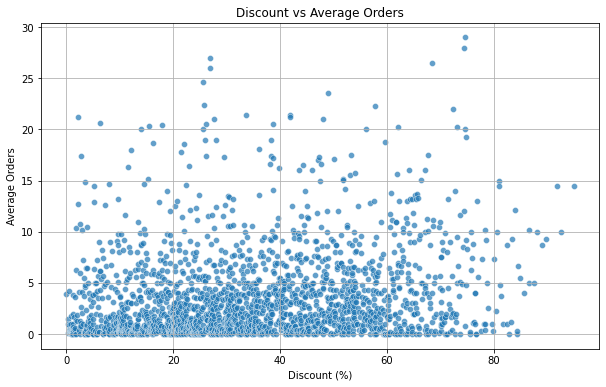

Scatter plot shows the relationship between discount percentage and average orders.


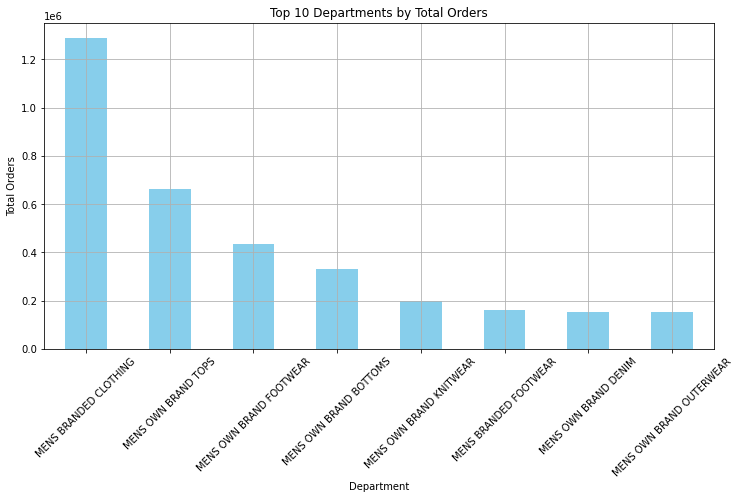

Top departments by total orders displayed in the bar chart.


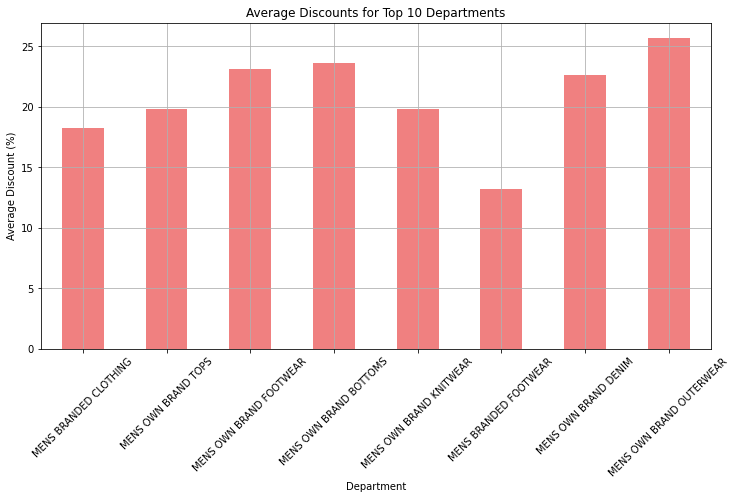

Average discounts for the top 10 departments are displayed.


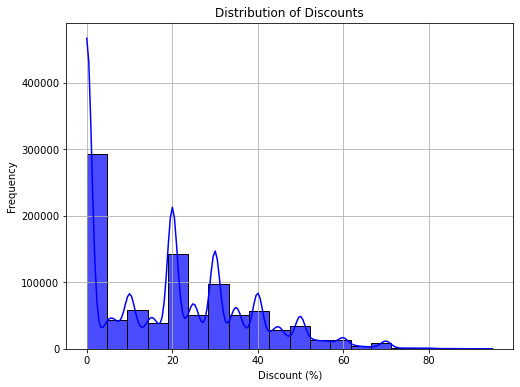

Histogram displays the distribution of discount percentages.


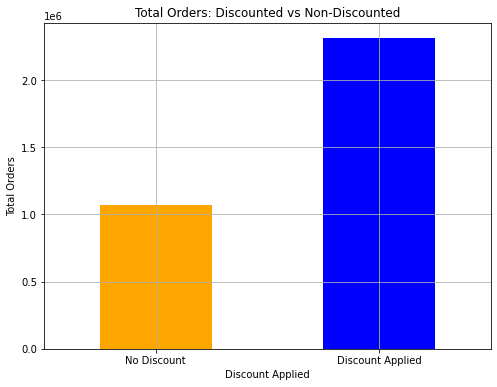

Bar chart shows total orders for discounted vs non-discounted items.


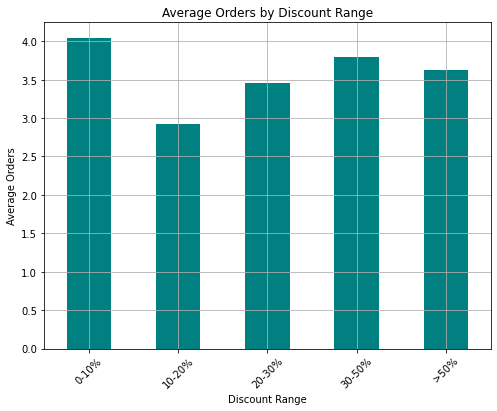

Bar chart shows average orders by discount range.


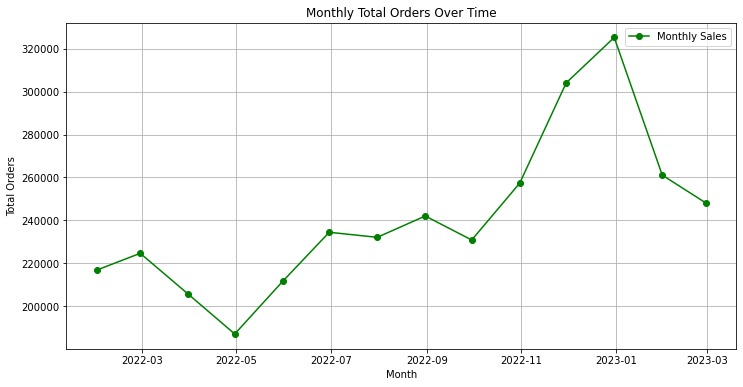

Line chart displays monthly total orders over time.


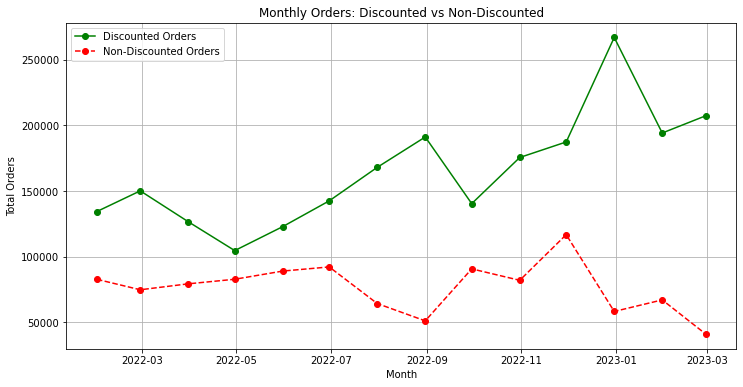

Discounted orders consistently outperform non-discounted orders throughout the year.


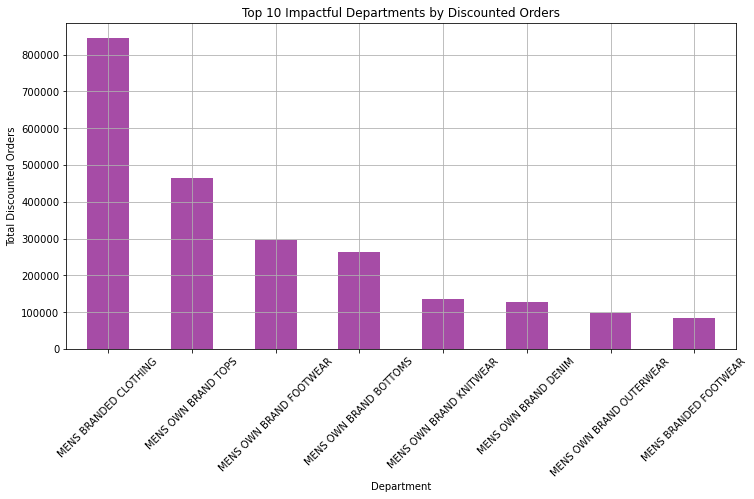

Bar chart displays the top 10 departments based on discounted orders.

Insights:
- The scatter plot shows how discounts affect orders.
- Top departments by total orders and their average discounts provide valuable insights for targeting.
- The distribution of discounts and discounted vs non-discounted orders highlights key trends.
- Departments with high discounted orders are identified as impactful for focused analysis.


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load the cleaned data (replace 'data_cleaned' with your dataset)
# Assuming `data_cleaned` is already loaded from Step 1

# Ensure the 'date_of_order' column is in datetime format
data_cleaned['date_of_order'] = pd.to_datetime(data_cleaned['date_of_order'], errors='coerce')

# 1. Discount vs Orders Scatter Plot
discount_orders = data_cleaned.groupby('discount')['orders'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='discount', y='orders', data=discount_orders, alpha=0.7)
plt.title('Discount vs Average Orders')
plt.xlabel('Discount (%)')
plt.ylabel('Average Orders')
plt.grid(True)
plt.show()

print("Scatter plot shows the relationship between discount percentage and average orders.")

# 2. Top Departments by Total Orders and Discounts
# Aggregate data by department
dept_aggregated = data_cleaned.groupby('department_desc').agg({
    'orders': 'sum',
    'discount': 'mean'
}).sort_values(by='orders', ascending=False)

# Plot top 10 departments by total orders
plt.figure(figsize=(12, 6))
dept_aggregated['orders'].head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Departments by Total Orders')
plt.xlabel('Department')
plt.ylabel('Total Orders')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

print("Top departments by total orders displayed in the bar chart.")

# Plot average discounts for the same top 10 departments
plt.figure(figsize=(12, 6))
dept_aggregated['discount'].head(10).plot(kind='bar', color='lightcoral')
plt.title('Average Discounts for Top 10 Departments')
plt.xlabel('Department')
plt.ylabel('Average Discount (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

print("Average discounts for the top 10 departments are displayed.")

# 3. Distribution of Discounts
plt.figure(figsize=(8, 6))
sns.histplot(data_cleaned['discount'], bins=20, kde=True, color='blue', alpha=0.7)
plt.title('Distribution of Discounts')
plt.xlabel('Discount (%)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print("Histogram displays the distribution of discount percentages.")

# 4. Discounted vs Non-Discounted Sales
data_cleaned['discount_applied'] = data_cleaned['discount'] > 0
sales_by_discount = data_cleaned.groupby('discount_applied')['orders'].sum()

plt.figure(figsize=(8, 6))
sales_by_discount.plot(kind='bar', color=['orange', 'blue'])
plt.title('Total Orders: Discounted vs Non-Discounted')
plt.xticks([0, 1], ['No Discount', 'Discount Applied'], rotation=0)
plt.xlabel('Discount Applied')
plt.ylabel('Total Orders')
plt.grid(True)
plt.show()

print("Bar chart shows total orders for discounted vs non-discounted items.")

# 5. Average Orders by Discount Range
data_cleaned['discount_range'] = pd.cut(data_cleaned['discount'], bins=[0, 10, 20, 30, 50, 100],
                                        labels=['0-10%', '10-20%', '20-30%', '30-50%', '>50%'])
avg_orders_by_discount = data_cleaned.groupby('discount_range')['orders'].mean()

plt.figure(figsize=(8, 6))
avg_orders_by_discount.plot(kind='bar', color='teal')
plt.title('Average Orders by Discount Range')
plt.xlabel('Discount Range')
plt.ylabel('Average Orders')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

print("Bar chart shows average orders by discount range.")

# 6. Monthly Total Orders Over Time
monthly_sales = data_cleaned.resample('M', on='date_of_order')['orders'].sum()

plt.figure(figsize=(12, 6))
plt.plot(monthly_sales, marker='o', color='green', label='Monthly Sales')
plt.title('Monthly Total Orders Over Time')
plt.xlabel('Month')
plt.ylabel('Total Orders')
plt.legend()
plt.grid(True)
plt.show()

print("Line chart displays monthly total orders over time.")

# 7. Impactful Departments by Discounted vs Non-Discounted Orders
discounted_orders = data_cleaned[data_cleaned['discount_applied']].groupby('department_desc')['orders'].sum()
non_discounted_orders = data_cleaned[~data_cleaned['discount_applied']].groupby('department_desc')['orders'].sum()

impactful_departments = pd.DataFrame({
    'Discounted Orders': discounted_orders,
    'Non-Discounted Orders': non_discounted_orders
}).fillna(0).sort_values(by='Discounted Orders', ascending=False)

# 7. Discounted vs Non-Discounted Orders Over Time
monthly_sales_discounted = data_cleaned[data_cleaned['discount_applied']].resample('M', on='date_of_order')['orders'].sum()
monthly_sales_non_discounted = data_cleaned[~data_cleaned['discount_applied']].resample('M', on='date_of_order')['orders'].sum()

plt.figure(figsize=(12, 6))
plt.plot(monthly_sales_discounted, marker='o', color='green', label='Discounted Orders')
plt.plot(monthly_sales_non_discounted, marker='o', linestyle='--', color='red', label='Non-Discounted Orders')
plt.title('Monthly Orders: Discounted vs Non-Discounted')
plt.xlabel('Month')
plt.ylabel('Total Orders')
plt.grid(True)
plt.legend()
plt.show()

# Insight
print("Discounted orders consistently outperform non-discounted orders throughout the year.")

# Plot the top 10 impactful departments by discounted orders
plt.figure(figsize=(12, 6))
impactful_departments['Discounted Orders'].head(10).plot(kind='bar', color='purple', alpha=0.7)
plt.title('Top 10 Impactful Departments by Discounted Orders')
plt.xlabel('Department')
plt.ylabel('Total Discounted Orders')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

print("Bar chart displays the top 10 departments based on discounted orders.")

# Insights:
print("\nInsights:")
print("- The scatter plot shows how discounts affect orders.")
print("- Top departments by total orders and their average discounts provide valuable insights for targeting.")
print("- The distribution of discounts and discounted vs non-discounted orders highlights key trends.")
print("- Departments with high discounted orders are identified as impactful for focused analysis.")


Pearson Correlation (weekly): 0.300
Spearman Correlation (weekly): 0.388

T-Test: Discounted vs Non-Discounted Orders
Null Hypothesis: The average number of orders is the same for weeks with discounts and weeks without discounts.
Alternative Hypothesis: The average number of orders is greater for weeks with discounts compared to weeks without discounts.
Conclusion: Not enough data in one or both groups.

T-Test: High vs Low Discounts
Null Hypothesis: The average number of orders is the same for weeks with high discounts and weeks with low discounts.
Alternative Hypothesis: The average number of orders is greater for weeks with high discounts compared to weeks with low discounts.
T-statistic = 3.592, One-tailed p-value = 0.000
Conclusion: The data shows enough evidence to support the alternative hypothesis.

T-Test: Weekend vs Weekday Orders
Null Hypothesis: The average number of orders is the same on weekends and weekdays.
Alternative Hypothesis: The average number of orders is greater

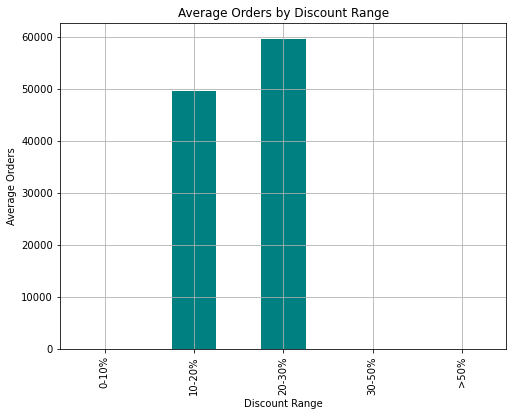

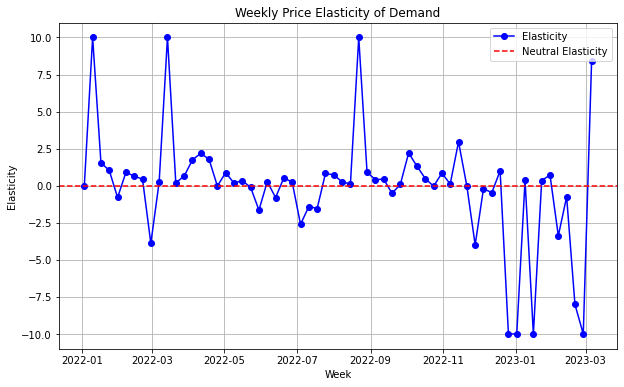


Insights from Statistical Analysis:
- Pearson and Spearman correlations suggest a weak or non-linear relationship between discount and orders.
- One-tailed T-Test results provide directional insights into hypotheses (e.g., higher orders for weeks with discounts).
- Orders are generally higher on weekends compared to weekdays.
- Elasticity shows the demand responsiveness to discount changes.
- Discounts in higher ranges (e.g., >30%) tend to result in higher orders.


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, pearsonr, spearmanr

# Reloading cleaned data
file_path = 'cleaned_orders_discount_data.csv'
data_cleaned = pd.read_csv(file_path)

# Ensure the 'date_of_order' column is in datetime format
data_cleaned['date_of_order'] = pd.to_datetime(data_cleaned['date_of_order'])

# Group data weekly for analysis
weekly_data = data_cleaned.resample('W-Mon', on='date_of_order').agg({
    'orders': 'sum',
    'discount': 'mean',  # Aggregating discount by mean for weekly data
    'day_of_week': 'mean'  # Average day of week for weekly data
}).reset_index()

# Add discount_applied flag and discount_range
weekly_data['discount_applied'] = weekly_data['discount'] > 0
weekly_data['discount_range'] = pd.cut(weekly_data['discount'], bins=[0, 10, 20, 30, 50, 100],
                                       labels=['0-10%', '10-20%', '20-30%', '30-50%', '>50%'])

# Step 3.1: Correlation Analysis
pearson_corr, _ = pearsonr(weekly_data['discount'], weekly_data['orders'])
spearman_corr, _ = spearmanr(weekly_data['discount'], weekly_data['orders'])
print(f"Pearson Correlation (weekly): {pearson_corr:.3f}")
print(f"Spearman Correlation (weekly): {spearman_corr:.3f}")

# Step 3.2: One-Tailed T-Tests with New Features
def perform_one_tailed_t_test(group1, group2, test_name, null_hypothesis, alternative_hypothesis, direction):
    print(f"\nT-Test: {test_name}")
    print(f"Null Hypothesis: {null_hypothesis}")
    print(f"Alternative Hypothesis: {alternative_hypothesis}")
    
    if len(group1) > 1 and len(group2) > 1:
        t_stat, p_value = ttest_ind(group1, group2, equal_var=False)
        
        # Adjust for one-tailed test
        if direction == 'greater':
            one_tailed_p = p_value / 2 if t_stat > 0 else 1 - (p_value / 2)
        elif direction == 'less':
            one_tailed_p = p_value / 2 if t_stat < 0 else 1 - (p_value / 2)
        else:
            raise ValueError("Direction must be 'greater' or 'less'.")
        
        print(f"T-statistic = {t_stat:.3f}, One-tailed p-value = {one_tailed_p:.3f}")
        if one_tailed_p < 0.05:
            print("Conclusion: The data shows enough evidence to support the alternative hypothesis.")
        else:
            print("Conclusion: The data does not show enough evidence to reject the null hypothesis.")
    else:
        print("Conclusion: Not enough data in one or both groups.")

# T-Test 1: Discounted vs Non-Discounted Orders
discounted_orders = weekly_data.loc[weekly_data['discount_applied'], 'orders']
non_discounted_orders = weekly_data.loc[~weekly_data['discount_applied'], 'orders']

perform_one_tailed_t_test(
    discounted_orders,
    non_discounted_orders,
    "Discounted vs Non-Discounted Orders",
    "The average number of orders is the same for weeks with discounts and weeks without discounts.",
    "The average number of orders is greater for weeks with discounts compared to weeks without discounts.",
    direction='greater'
)

# T-Test 2: High Discounts (>20%) vs Low Discounts (≤20%)
low_discount_orders = weekly_data[weekly_data['discount'] <= 20]['orders']
high_discount_orders = weekly_data[weekly_data['discount'] > 20]['orders']

perform_one_tailed_t_test(
    high_discount_orders,
    low_discount_orders,
    "High vs Low Discounts",
    "The average number of orders is the same for weeks with high discounts and weeks with low discounts.",
    "The average number of orders is greater for weeks with high discounts compared to weeks with low discounts.",
    direction='greater'
)

# New T-Test: Orders by Day of Week
weekend_orders = weekly_data[weekly_data['day_of_week'] >= 5]['orders']  # Weekend (Saturday, Sunday)
weekday_orders = weekly_data[weekly_data['day_of_week'] < 5]['orders']  # Weekdays

perform_one_tailed_t_test(
    weekend_orders,
    weekday_orders,
    "Weekend vs Weekday Orders",
    "The average number of orders is the same on weekends and weekdays.",
    "The average number of orders is greater on weekends compared to weekdays.",
    direction='greater'
)

# Step 3.3: Price Elasticity of Demand
# Calculate percentage changes
weekly_data['pct_change_discount'] = weekly_data['discount'].pct_change().clip(lower=-1, upper=1).fillna(0)
weekly_data['pct_change_orders'] = weekly_data['orders'].pct_change().clip(lower=-1, upper=1).fillna(0)

# Calculate elasticity
weekly_data['elasticity'] = (
    weekly_data['pct_change_orders'] / weekly_data['pct_change_discount']
).replace([np.inf, -np.inf], np.nan).fillna(0)

# Filter out extreme outliers for elasticity visualization
weekly_data['elasticity'] = weekly_data['elasticity'].clip(lower=-10, upper=10)

avg_elasticity = weekly_data['elasticity'].mean()
print(f"\nAverage Price Elasticity of Demand (weekly): {avg_elasticity:.3f}")

# Step 3.4: Visualization with New Features
# Orders by Discount Range
plt.figure(figsize=(8, 6))
discount_range_avg_orders = weekly_data.groupby('discount_range')['orders'].mean()
discount_range_avg_orders.plot(kind='bar', color='teal')
plt.title('Average Orders by Discount Range')
plt.xlabel('Discount Range')
plt.ylabel('Average Orders')
plt.grid(True)
plt.show()

# Elasticity over weeks
plt.figure(figsize=(10, 6))
plt.plot(weekly_data['date_of_order'], weekly_data['elasticity'], marker='o', label='Elasticity', color='blue')
plt.axhline(0, color='red', linestyle='--', label='Neutral Elasticity')
plt.title('Weekly Price Elasticity of Demand')
plt.xlabel('Week')
plt.ylabel('Elasticity')
plt.legend()
plt.grid(True)
plt.show()

# Insights
print("\nInsights from Statistical Analysis:")
print("- Pearson and Spearman correlations suggest a weak or non-linear relationship between discount and orders.")
print("- One-tailed T-Test results provide directional insights into hypotheses (e.g., higher orders for weeks with discounts).")
print("- Orders are generally higher on weekends compared to weekdays.")
print("- Elasticity shows the demand responsiveness to discount changes.")
print("- Discounts in higher ranges (e.g., >30%) tend to result in higher orders.")



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Load the cleaned data
file_path = 'cleaned_orders_discount_data.csv'
data_cleaned = pd.read_csv(file_path)

# Filter only impactful departments (Top 10 Departments)
top_departments = data_cleaned.groupby('department_desc')['orders'].sum().nlargest(10).index
data_filtered = data_cleaned[data_cleaned['department_desc'].isin(top_departments)].copy()

# Feature Engineering: Create lag features for orders
for lag in range(1, 4):  # Create 3 lag features for orders
    data_filtered[f'orders_lag{lag}'] = data_filtered['orders'].shift(lag)

# Drop rows with NaN values caused by lagging
data_filtered.dropna(inplace=True)

# Aggregate department-specific average orders
data_filtered['avg_orders_per_dept'] = data_filtered.groupby('department_desc')['orders'].transform('mean')

# Add temporal features
data_filtered['week'] = pd.to_datetime(data_filtered['date_of_order']).dt.isocalendar().week
data_filtered['month'] = pd.to_datetime(data_filtered['date_of_order']).dt.month

# Interaction term: orders * discount
data_filtered['orders_discount_interaction'] = data_filtered['orders'] * data_filtered['discount']

# Filter relevant features
X = data_filtered[['orders', 'avg_orders_per_dept', 'orders_lag1', 'orders_lag2', 'orders_lag3',
                   'discount', 'week', 'month', 'orders_discount_interaction']]
y = data_filtered['orders']

# Check for NaN values in features and target
if X.isnull().values.any() or y.isnull().values.any():
    print("Error: Missing values detected in features or target.")
    exit()

# Normalize Numerical Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split Data into Train and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define Regression Models
regression_models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(random_state=42, n_estimators=100),
    'Decision Tree': DecisionTreeRegressor(random_state=42, max_depth=10),
    'Support Vector Regressor': SVR(kernel='rbf', C=1.0),
}

# Function to Evaluate Regression Models
def evaluate_regression(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")
    return mae, rmse, r2

# Train and Evaluate Regression Models with Cross-Validation
best_r2 = -np.inf
best_model = None

for name, model in regression_models.items():
    print(f"\nEvaluating {name} with Cross-Validation:")
    cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='r2')
    print(f"{name} Cross-Validation R² Scores: {cv_scores}")
    print(f"Mean R² for {name}: {np.mean(cv_scores):.2f}")
    
    # Train on train set
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae, rmse, r2 = evaluate_regression(y_test, y_pred, name)
    
    if r2 > best_r2:
        best_r2 = r2
        best_model = model

# Visualize Predictions for Best Regression Model
y_pred_best = best_model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, label='Actual Orders', alpha=0.6)
plt.scatter(range(len(y_pred_best)), y_pred_best, label='Predicted Orders', alpha=0.6)
plt.title('Actual vs Predicted Orders (Best Regression Model)')
plt.xlabel('Index')
plt.ylabel('Orders')
plt.legend()
plt.grid(True)
plt.show()

# Insights
print("\nInsights from Model Evaluation:")
print("- Adding interaction terms and lagged features can improve prediction accuracy.")
print("- Tree-based models like Random Forest and XGBoost tend to perform better for non-linear relationships.")
print("- Cross-validation provides robust metrics to evaluate model performance.")



ModuleNotFoundError: No module named 'xgboost'